# Regional residual separation example

This code illustrates how to compute the regional residual separation of total-field anomaly data by using a simple polynomial fit.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag.fields import rectangular_prism as rp
from gravmag import plot_functions as plf

### Model

In [2]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., 1000, 3500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
magnetization = np.array([[1.4, 30, -10],
                          [1.6, 30, -10],
                          [1.1, 60, 40],
                          [1.2, -20, -75]])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

### Main field

In [4]:
# reference point
yc, xc = 0, 1000

# inclination (degrees)
I0 = 60 - 1e-4*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# declination (degrees)
D0 = -43 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# intensity (nT)
F0 = 23400 + 1e-4*(xp-xc) + 1e-4*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

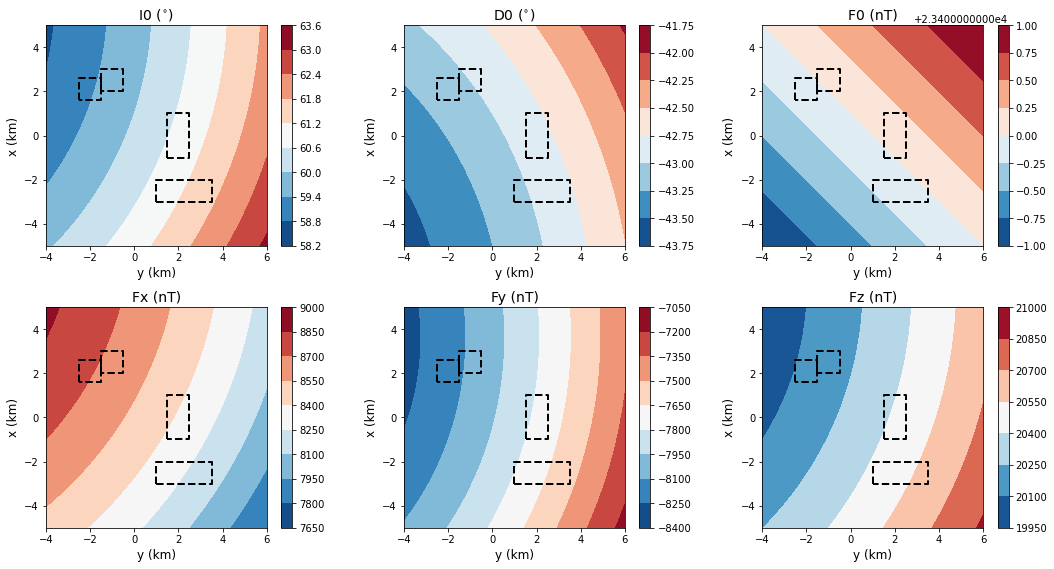

In [5]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic residual field

In [6]:
# Compute the magnetic field components
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0
approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### Synthetic regional field

In [7]:
X = xp-np.mean(xp)
Y = yp-np.mean(yp)
regional_tfa = 400 - 1e-2*X + 1e-2*Y + 1e-8*X*X + 1e-8*Y*Y

total_tfa = regional_tfa + tfa

### Plot the data

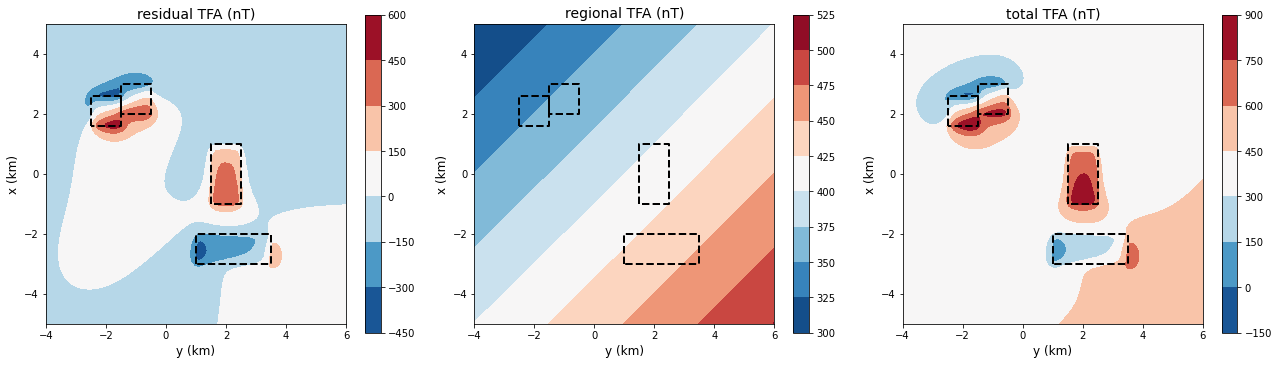

In [8]:
fields = [tfa, regional_tfa, total_tfa]
windows = [1, 2, 3]
titles = ['residual TFA (nT)', 'regional TFA (nT)', 'total TFA (nT)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Estimate the regional field

In [9]:
# Matrix defining the regional polynomial
#A = np.polynomial.polynomial.polyvander2d(x=yp, y=xp, deg=[1,1])
A = np.vstack([np.ones(xp.size), yp, xp]).T

In [10]:
# Estimate the coefficients of the polynomial 
# representing the regional field
ATA = np.dot(A.T,A)
ATd = np.dot(A.T,total_tfa)
p = np.linalg.solve(ATA, ATd)

In [11]:
# Estimated regional field
estimated_regional_tfa = np.dot(A, p)

diff_regional = estimated_regional_tfa - regional_tfa

In [12]:
# Estimated residual tfa
estimated_residual_tfa = total_tfa - estimated_regional_tfa

diff_residual = estimated_residual_tfa - tfa

### Plot the results

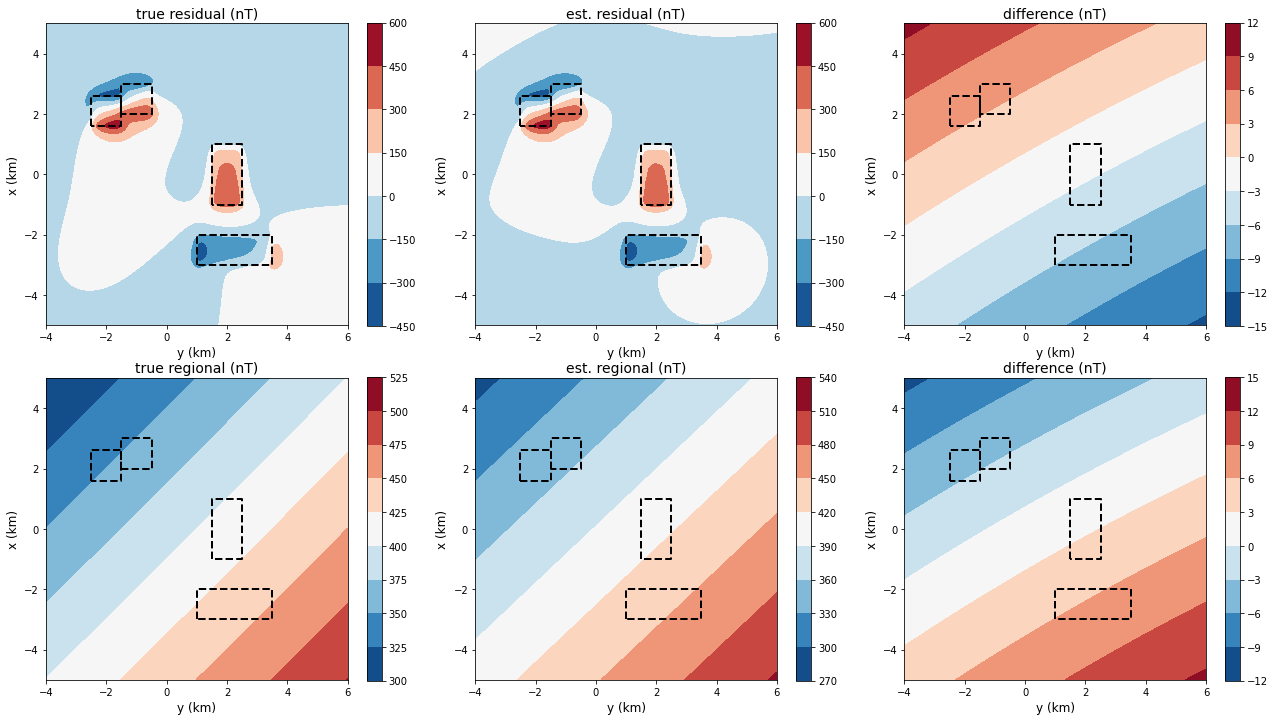

In [13]:
fields = [tfa, estimated_residual_tfa, diff_residual,
          regional_tfa, estimated_regional_tfa, diff_regional]
windows = [1, 2, 3, 4, 5, 6]
titles = ['true residual (nT)', 'est. residual (nT)', 'difference (nT)',
          'true regional (nT)', 'est. regional (nT)', 'difference (nT)']

plt.figure(figsize=(18,10))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()